# PyTorch Code from Kernel to Convolutional Neural Network


The following material was initially prepared as a lecture for <strong>CSCI 4701: Deep Learning (Spring 2025)</strong> course at ADA University. The notebook is the continuation of my lectures called <a href='https://shahaliyev.org/writings/backprop'>Python Code from Derivatives to Backpropagation</a> and <a href='https://shahaliyev.org/writings/neural_network'>Python Code from Neuron to Neural Network</a>.

### Table of Contents

- Image Dimensions
- MNIST Dataset
- Training Custom PyTorch Model on MNIST
- Cross-Correlation Operation
- Kernels
- Padding & Stride
- Increasing Dimensions
- Maximum & Average Pooling
- Convolutional Neural Network
- Sequential Module in PyTorch
- Training & Inference

In previous lectures, we learned how to build a neural network. We will come back to discuss many optimization and regularization techniques (e.g. parameter initialization, momentum, weight decay, dropout, batch normalization, etc.) to improve the efficiency of our training. But before coming back to these important notions, we will discuss Convolutional Neural Networks (CNN) which are used in image processing. And even before that, we wil learn what an image is.

## Image Dimensions

 A grayscale image is simply a 2D array holding pixel values, often ranging between `0` and `1` (normalized) or `0` and `255` (8-bit image), representing the range of intensities between black and white. A colored image often is represented by the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model), where we have 3 sets (channels) of 2D arrays for Red, Green, and Blue. Combinations of three values represent additional colors to black and white (e.g. `[255, 0, 0]` is red).

We will create a toy image to get a feeling of how images are stored in the memory. We will also delibarately use `torch` library to familiarize ourselves with `PyTorch` functions. In `PyTorch`, images are stored in `(C, H, W)` format, corresponding to channel, height, and width. Note that batch size can also be included `(B, C, H, W)`. _Batch_ is simply a subset of a dataset. We  should process our dataset in batches in order to not load all the images at once to the RAM memory, which is usually limited to several `Gigabytes` (see the top right corner of a `Colab` notebook for RAM information). [Tensor](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) is the main data abstraction in PyTorch, similar to `numpy` arrays. Tensors are optimized for GPU and can calculate gradients with its [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) engine (i.e. advanced [micrograd](https://github.com/karpathy/micrograd)), which we saw in the previous lecture.

In [1]:
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# this is for plotting, skip for now
def plot(img_tensors, titles=None):
  if not isinstance(img_tensors, list):
    img_tensors = [img_tensors]
  if not isinstance(titles, list):
    titles = [titles] * len(img_tensors)

  fig, axes = plt.subplots(1, len(img_tensors), figsize=(len(img_tensors) * 4, 4))
  if len(img_tensors) == 1:
    axes = [axes]

  for ax, img_tensor, title in zip(axes, img_tensors, titles):

    img_tensor = img_tensor.cpu()
    img = img_tensor.permute(1, 2, 0).numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis("off")

  plt.show()

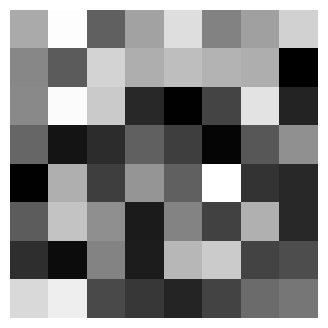

In [3]:
color = ['gray','rgb'][0] # change 0 to 1 for rgb

H = W = 8
C = 3 if color == 'rgb' else 1

img = torch.rand((C, H, W))
plot(img)

In [4]:
img

tensor([[[0.6681, 0.9885, 0.3858, 0.6401, 0.8704, 0.5164, 0.6299, 0.8198],
         [0.5352, 0.3675, 0.8261, 0.6846, 0.7454, 0.7086, 0.6866, 0.0161],
         [0.5431, 0.9798, 0.7918, 0.1760, 0.0203, 0.2780, 0.8877, 0.1514],
         [0.4076, 0.0945, 0.1907, 0.3847, 0.2569, 0.0359, 0.3500, 0.5701],
         [0.0235, 0.6880, 0.2567, 0.5896, 0.3844, 0.9977, 0.2146, 0.1763],
         [0.3725, 0.7660, 0.5657, 0.1217, 0.5217, 0.2664, 0.6946, 0.1770],
         [0.1950, 0.0631, 0.5228, 0.1239, 0.7185, 0.7971, 0.2741, 0.3123],
         [0.8518, 0.9311, 0.3031, 0.2274, 0.1595, 0.2751, 0.4300, 0.4698]]])

Technically, if we have a label for the image, and enough images in the dataset, we can already train a neural network to make predictions. For that, we can turn our 2D (grayscale) or 3D (RGB) tensors into vectors and feed in to our model. For example, and image with input dimensions (3,32,32), which corresponds to a 32x32 pixel RGB image, can be reshaped into a single dimensional vector of size (3 \* 32 \* 32) which will be the input dimension of our network.

**Question:** What will be the shape of 8x8 grayscale image after reshaping?

In [5]:
img.view(-1)

tensor([0.6681, 0.9885, 0.3858, 0.6401, 0.8704, 0.5164, 0.6299, 0.8198, 0.5352,
        0.3675, 0.8261, 0.6846, 0.7454, 0.7086, 0.6866, 0.0161, 0.5431, 0.9798,
        0.7918, 0.1760, 0.0203, 0.2780, 0.8877, 0.1514, 0.4076, 0.0945, 0.1907,
        0.3847, 0.2569, 0.0359, 0.3500, 0.5701, 0.0235, 0.6880, 0.2567, 0.5896,
        0.3844, 0.9977, 0.2146, 0.1763, 0.3725, 0.7660, 0.5657, 0.1217, 0.5217,
        0.2664, 0.6946, 0.1770, 0.1950, 0.0631, 0.5228, 0.1239, 0.7185, 0.7971,
        0.2741, 0.3123, 0.8518, 0.9311, 0.3031, 0.2274, 0.1595, 0.2751, 0.4300,
        0.4698])

## MNIST Dataset

We will download and train our model on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which has 70,000 grayscale 28x28 images of hand-written digits with their labels. Our main goal is to familiarize ourselves with `PyTorch`. Make sure to go through the [Datasets and DataLoaders tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Even though it won't be essential for understanding this notebook, try to answer the following questions: What other [transforms](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html) can we apply to our dataset and why? Why do we _shuffle_ the `train` data but not the `test` data? What are `num_workers` and `batch_size`?

In [7]:
train_data = datasets.MNIST(root='./data', train=True,  transform=transforms.ToTensor(), download=True)
test_data  = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=2, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=64, num_workers=2, shuffle=False)

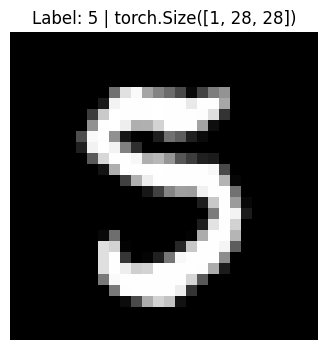

In [15]:
X_train, y_train = next(iter(train_loader)) # gets the images of the batch
plot(X_train[0], f'Label: {y_train[0].item()} | {X_train[0].shape}')

There are many ways to collapse our multi-dimensional image tensor into a single dimension. It is worth understanding the [internals of PyTorch](http://blog.ezyang.com/2019/05/pytorch-internals/) and the workings of the equivalent methods below, especially the difference of memory management between `reshape` and `view` functions. We can also see the number of elements with `numel`.

In [16]:
# X_train[0].view(-1).shape[0]
# X_train[0].reshape(-1).shape[0]
# X_train[0].flatten().shape[0]
X_train[0].numel() # 1x28x28

784

## Training Custom PyTorch Model on MNIST

We will now build a simple neural network and train our model on MNIST, but not from scratch :). When we build our custom network, we need to inherit from `torch.nn.Module` which will handle many useful operations (e.g. autograd). It will also enforce us to define our `forward` pass function. Our activation will be `ReLU` function. Fully Connected (FC) layer (also known as Dense Layer) is simply a network layer where all the neurons are connected to the previous layer neurons (recall: MLP). When applying forward pass, we should reshape our input dimensions from `(B, C, H, W)` to `(B, C*H*W)`, so that we can pass the input from `train_loader` to our FC layer.

**Exercise:** Implement different ways of reshaping tensor `(B, C, H, W)` to `(B, C*H*W)`.

In [17]:
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()

  def forward(self, X):
    X = X.view(X.shape[0], -1)
    return self.fc2(self.relu(self.fc1(X)))

We will now initialize our model, define our loss and [optimizer](https://pytorch.org/docs/stable/optim.html). [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) approximates gradient descent accross data batches to achieve faster performance. We will discuss `Adam` optimizer in the future as well.

**Question:** What should be the input and output layer sizes of our model?

**Question:** What should be our loss function and why?

**Exercise:** Change `SGD` optimizer to `Adam` and retrain the model and note the training performance and inference accuracy.

In [18]:
model = MLP(784, 128, 10)
cel = nn.CrossEntropyLoss() # for multiclass classification
optimizer = optim.SGD(model.parameters(), lr=0.001)

It is possible to run faster training calculations on GPU with `cuda`. It is possible to change the runtime in Google Colab through the menu `Runtime -> Change runtime type`. We will move our model's parameters to the available device with `.to()`.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

As `PyTorch` is highly optimized and the dataset images are small in size, training will be quick, especially with GPU. We should move our data in batches to the GPU memory as well in order to make it compatible with the model. Backpropagation steps we have repeatedly discussed in the previous lectures. We will train out model for only three epochs to quickly see interesting mistakes of our model, but feel free to train the model for a longer period to achieve a higher accuracy.

In [20]:
num_epochs = 3
for epoch in range(num_epochs):
  loss = 0.0
  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    preds = model(X_train)
    batch_loss = cel(preds, y_train)
    batch_loss.backward()
    optimizer.step()
    loss += batch_loss.item()
  print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss/len(train_loader):.4f}")

Epoch: 1/3, Loss: 2.2294
Epoch: 2/3, Loss: 2.0287
Epoch: 3/3, Loss: 1.7497


Forward passing unseen data through a trained network to measure how well the model is doing is called _inference_. In this stage, we do not need to calculate gradients (`torch.no_grad()`). We will also call `model.eval()` which is not necessary for our simple network, yet is a good practice to follow. As `y_test` is a tensor of batch size and the output dimension `(B, 10)`, we will find top prediction labels on each batch (`dim=1`) and store them for future visualization. We will then sum the correct predictions and divide by the image count in the test dataset to get the final accuracy score.

In [21]:
model.eval()

correct = 0
all_preds = []
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)
    preds = model(X_test)
    _, top_preds = torch.max(preds, dim=1)
    correct += (top_preds == y_test).sum().item()
    all_preds.append(top_preds)

accuracy = 100 * correct / len(test_loader.dataset)
print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 76.14%


Let's visualize some of our predictions in the last test batch. Pay attention to the false predictions of our model. Can you guess why the model could have made those mistakes?

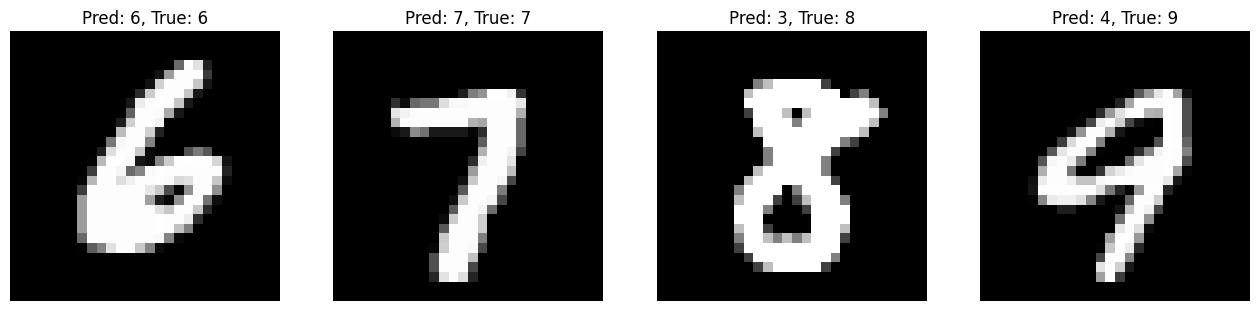

In [25]:
plot(
    [X_test[i] for i in range(4)],
    [f"Pred: {all_preds[-1][i]}, True: {y_test[i]}" for i in range(4)]
)

Our simple MLP with two FC layers acheived a pretty high accuracy. But that was mainly due to the simplicity of the dataset. Processing bigger datasets, also with a more challenging goal in mind (e.g. object detection, segmentation, etc), in addition to huge computational resources, requires from a model to understand **spatial relationship** in the images. When we reshape our image pixels into a single dimension two major things happen: 1) input size of our neurons drastically increases (a 224x224 pixel RGB image is more than 150,000 input dimension for a FC neuron), and 2) we lose important information about the pixels: their spatial location. It would make sense, if we could somehow also train our model to learn, for example, which pixels are close to each other. Most probably a combination of pixels (_superpixels_) make up a wheel of a car, or an ear of an animal. It would be great to look at pixels not as distinct and unrelated items (which FC layer does), but as connected and spatially related items.

## Cross-Correlation Operation

The word "convolution" is actually a [misnomer](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html), and "cross-correlation" would be a more precise name for the operation which we will describe now. The image below is `figure 7.2.1` from the [Dive into Deep Learning](https://d2l.ai/) book. As can be seen, we have a 2D input tensor (image) and a _kernel_ of size `2x2`. We can put full kernel onto four different locations in the image (top left, which we see in the image, top right, bottom left and bottom right) and calculate the output. And the output is calculated by a simple dot product: all the overlapping values are multiplied to each other and summed up. The output in the image is calculated as `0*0+1*1+3*2+4*3=19`.

**Question:** Given the image dimensions and the kernel size, how many times can we move kernel over the image?

![Cross-Correlation operation](https://d2l.ai/_images/correlation.svg)

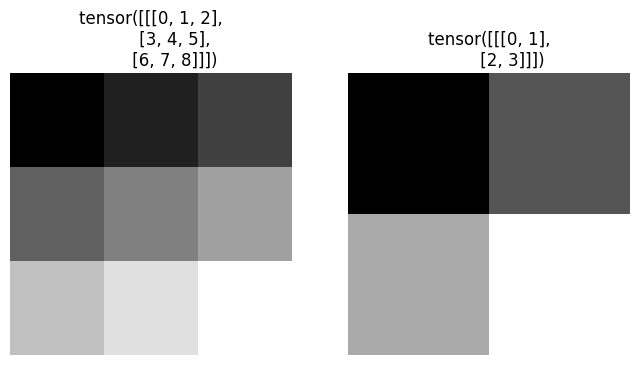

In [26]:
img = torch.arange(9).reshape((1,3,3))
kernel = torch.arange(4).reshape((1,2,2))
plot([img, kernel], [f'{img}', f'{kernel}'])

If the kernel width is the same as image width, we can put kernel only once on each row of the image. If kernel width is `1` pixel less than the image width dimension, we can put kernel twice on the image row. The same rule applies to height and vertical movement of the kernel over the image. From that, we can determine the number of steps kernel will move over the image.

In [27]:
horizontal_steps = img.shape[1] - kernel.shape[1] + 1 # height
vertical_steps   = img.shape[2] - kernel.shape[2] + 1 # width

We will now use for loops for calculating cross-correlation operation, but note that we do it for simplicity, and using loops isn't an efficient choice. Whenever we can, we should use vectorized operations provided by `Pytroch`. Finally, pay attention how `squeeze/unsqueeze` functions take care of the channel dimension below.

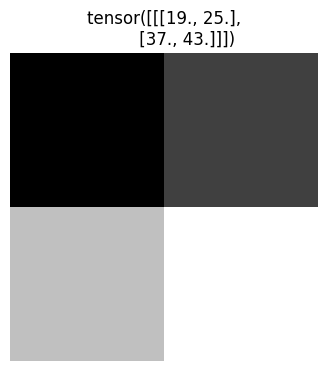

In [28]:
out = torch.zeros((horizontal_steps, vertical_steps))
for i in range(horizontal_steps):
  for j in range(vertical_steps):
    patch = img.squeeze()[i:kernel.shape[1]+i, j:kernel.shape[2]+j]
    out[i, j] = torch.sum(kernel.squeeze() * patch)
out = out.unsqueeze(0)

plot(out, f'{out}')

The good news is that we do not have to implement complicated (and inefficient) cross-correlation operations in higher dimensions. `torch.nn.functional` provides functions for that, which, however accept arguments in 4-dimensions, the first dimension being batch size. Again, pay attention to `squeeze` and `unsqueeze` dimension values, which will add and remove the fourth (batch) dimension.

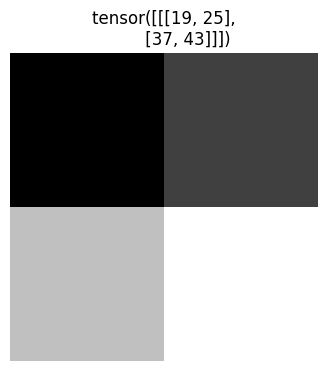

In [29]:
import torch.nn.functional as F

out = F.conv2d(img.unsqueeze(0), kernel.unsqueeze(0)).squeeze(1)
plot(out, f'{out}')

## Kernels

Kernels are capable of extracting relevant features from images. We can choose different kernels, depending on what we try to detect in the image. To see how kernel values influence the output of the cross-correlation operation, let's see the following edge detection example. Edges in the toy image below are the points where pixel values change extremely (from 0 to 1 or vice versa).

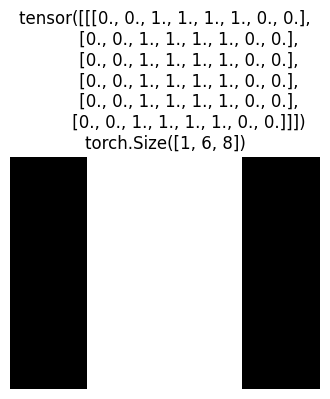

In [30]:
img = torch.zeros((1, 6, 8))
img[:, :, 2:6] = 1.0
plot(img, f'{img}\n{img.shape}')

**Question:** What kind of kernel would be appropriate for detecting edges?

Try to understand why the code below detects the edges. Hint: manually calculate a cross-correlation step.

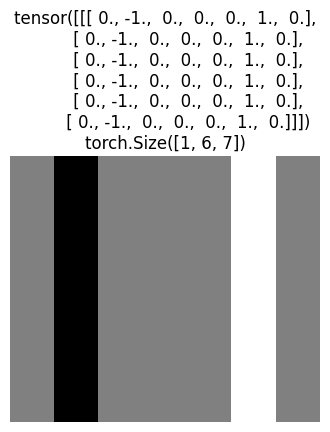

In [31]:
kernel = torch.tensor([[[1.0, -1.0]]])
out = F.conv2d(img.unsqueeze(0), kernel.unsqueeze(0)).squeeze(1)
plot(out, f'{out}\n{out.shape}')

There exists [many ready kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Details) for getting different image features (e.g. sharpening, blurring, edge detection, etc). But what if we wanted to learn more complicated kernels, how to achieve that? Can we learn correct kernel values, say, for detecting an ear of a dog? It turns out backpropagation will help with that as well. Given image and the edge detected output, we can learn the kernel. Instead of MLP with linear (FC, Dense) layers, we will use a single convolutional layer provided by `PyTorch` to learn the kernel. `nn.Conv2d` requires from us to specify the input dimensions, when `nn.LazyConv2d` will determine the dimension dynamically, when we pass the input image to the model. Note that we are overfitting the model (layer) to a single example. Our goal is to learn a single kernel of size `(1,2)` for a grayscale image. What the convolutional layer does under the hood we will learn soon.

In [32]:
model = nn.LazyConv2d(out_channels=1, kernel_size=(1, 2)).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_img = img.to(device).unsqueeze(0)
y_out = out.to(device).unsqueeze(0)

num_epochs = 50
for i in range(num_epochs):
  optimizer.zero_grad()
  preds = model(X_img)
  loss = torch.sum((preds - y_out) ** 2) # mse
  loss.backward()
  optimizer.step()

print(f'Epoch: {i+1}/{num_epochs}, Loss: {loss:.4f}')
print(f'Learned Kernel: {model.weight.data}')

Epoch: 50/50, Loss: 0.0000
Learned Kernel: tensor([[[[ 0.9987, -0.9987]]]])


Just to see what kernels are capable of, you can try out different kernels and see their outputs on an image in an [interactive visualization](https://setosa.io/ev/image-kernels/). But here, let's take 1) a simple blur kernel which averages pixels within its frame, and 2) a Gaussian blur kernel which is basically giving more weight to the pixels that are closer to the middle, by considering Gaussian (normal) distribution (see nice [demonstration](https://www.youtube.com/watch?v=8rrHTtUzyZA)). We will apply them on a [photo](https://en.wikipedia.org/wiki/Eileen_Collins) and see the output. Note that [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) is commonly used for detecting edges (increase the size of the kernel and see the output). _3Blue1Brown_ video called "[But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA&t=538s)" explains cross-correlation and kernel operations in a nice visual way.

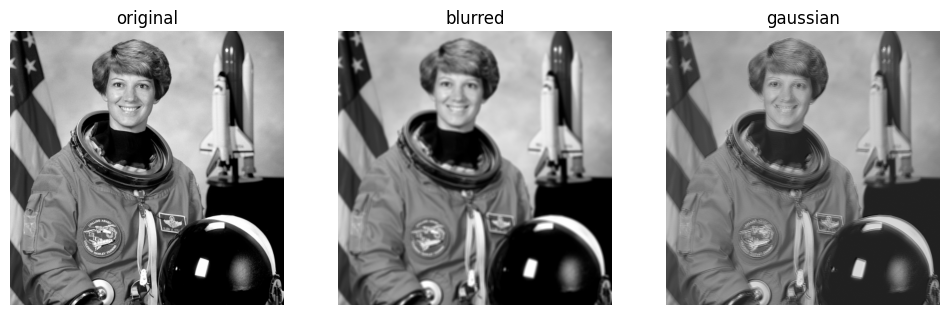

In [34]:
from skimage import data

test_img = data.astronaut()
test_img = torch.tensor(test_img, dtype=torch.float32).permute(2,0,1) # C, H, W
test_img = test_img.mean(0).unsqueeze(0) # RGB to grayscale

H = W = 5 # try out bigger kernel sizes
mean, std = 0.0, 1.0 # mean and standard deviation of Gaussian distribution

blur_kernel = torch.ones((1,H,W)) * 1/H*W # averaging pixels
gaussian_blur_kernel = torch.normal(mean, std, size=(1,H,W)) # pixels closer to middle get more weight

blurred  = F.conv2d(test_img.unsqueeze(0), blur_kernel.unsqueeze(0)).squeeze(1)
gaussian = F.conv2d(test_img.unsqueeze(0), gaussian_blur_kernel.unsqueeze(0)).squeeze(1)

plot([test_img, blurred, gaussian], ['original', 'blurred', 'gaussian'])

## Padding & Stride

By Michael Plotke - Own work ([CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0) / [Wikimedia Commons](https://commons.wikimedia.org/w/index.php?curid=24288958))

![Cross-Correlation (Convolution) with Padding](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

When we find `valid` cross-correlation, we move kernel within the constraints of the image. As a consequence, we pass through boundaries only once, losing some spatial information (pixels on the corners are barely used). `Padding` resolves this issue.

By default, we step with kernel one row/column at a time (as in the image above). `Striding` determines the step size of our kernel, which is used when we want to reduce the output dimensionality after cross-correlation even further. It may be useful when the kernel size is big, we need faster computation, etc.  

From this point on, we will replace the more accurate word "cross-correlation" with the accepted terminology "convolution". Simply put, convolution operation is equivalent to the 90 degrees rotated cross-correlation operation.

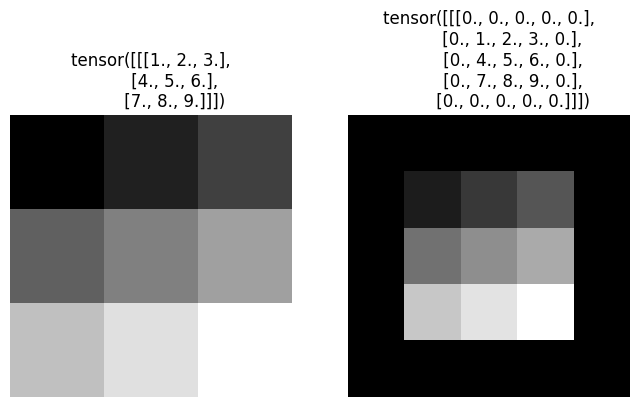

In [35]:
img = torch.arange(1., 10).reshape((1,3,3))
padded_img = F.pad(img, (1,1,1,1)) # left right top bottom
plot([img, padded_img], [f'{img}', f'{padded_img}'])

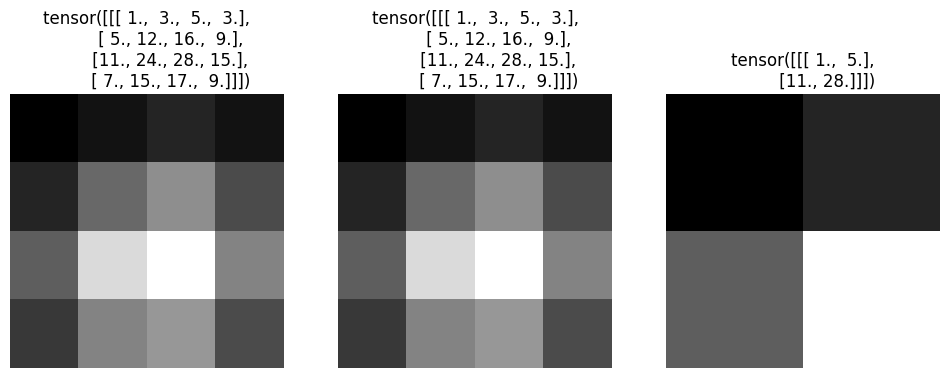

In [36]:
kernel = torch.ones((1,1,2,2))

manual_padding = F.conv2d(padded_img.unsqueeze(0), kernel).squeeze(1)
conv2d_padding = F.conv2d(img.unsqueeze(0), kernel, padding=1).squeeze(1)
conv2d_stride  = F.conv2d(img.unsqueeze(0), kernel, padding=1, stride=2).squeeze(1)

plot([manual_padding, conv2d_padding, conv2d_stride],
     [f'{manual_padding}', f'{conv2d_padding}', f'{conv2d_stride}'])

**Exercise:** Manually calculate the strided convolution above.


**Exercise:** Create 100 random images (colored) and calculate the output dimension after the convolution operation. Calculate and print out how many features will be passed to the next layer after flattening the feature maps for all the cases:

| Image Size | Kernel Size | Stride | Padding |
|------------|------------|--------|---------|
| 30x30     | 3x3        | 1      | 0       |
| 224x224   | 5x5        | 2      | 1       |
| 528x528   | 7x7        | 3      | 2       |

## Increasing Dimensions

So far we have been working with grayscale images. When we increase the dimension of channels `C`, we will simply have `C` number of kernels. We will apply convolution of each kernel to their corresponding channels and eventually sum them up. Below is [figure 7.4.1](https://d2l.ai/chapter_convolutional-neural-networks/channels.html).

![kernel convolution of multiple channels](https://d2l.ai/_images/conv-multi-in.svg)

In [37]:
img = torch.cat((torch.arange(9.), torch.arange(1.,10))).reshape((1,2,3,3))
img

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]],

         [[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])

In [38]:
kernels = torch.cat((torch.arange(4.), torch.arange(1.,5))).reshape((1,2,2,2))
kernels

tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]]]])

In [39]:
conv1 = F.conv2d(img[:,0:1,:,:], kernels[:,0:1,:,:])
conv2 = F.conv2d(img[:,1:2,:,:], kernels[:,1:2,:,:])

conv1 + conv2

tensor([[[[ 56.,  72.],
          [104., 120.]]]])

In [40]:
# or equivalently
F.conv2d(img, kernels)

tensor([[[[ 56.,  72.],
          [104., 120.]]]])

We may want to not only deal with multiple channels, but also output multiple channels. The simplistic reasoning for it could be that each output channel may hold different feature information. For that, we will apply convolution of each kernel set to the whole image (all dimensions) and eventually concatenate the results along the channel axis.

In [41]:
torch.cat([F.conv2d(img, kernels+i) for i in range(3)], dim=0)

tensor([[[[ 56.,  72.],
          [104., 120.]]],


        [[[ 76., 100.],
          [148., 172.]]],


        [[[ 96., 128.],
          [192., 224.]]]])

## Maximum & Average Pooling

As we know, the advantage of convolutional layers is that they take into account spatial information about the pixels (their locations, neighbors, etc). But how can we make sure that our predictions will not be very sensitive to small changes in pixel locations? Because a cat image where the cat is streching is still a cat image, and our model should correctly classify it, even if it hasn't seen a stretching cat during training. As we will see, applying a `pooling` layer will help with _spatial invariance_, as well as downsample the representations of the previous layer.

The image below ([figure 7.5.1](https://d2l.ai/chapter_convolutional-neural-networks/pooling.html)) describes _maximum pooling_ operation, which looks like a kernel, but instead of convolution, simply takes the maximum pixel value within that range. Similarly, an _average pooling_ operation, averages all the corresponding pixels and is equivalent to the simple blur kernel which we saw previously.

![Max pooling operation](https://d2l.ai/_images/pooling.svg)

In [42]:
img_channel = img.unbind(1)[0] # unbinds from the channel dimension and takes the first channel
img_channel

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]])

In [43]:
operation = ['avg','max'][1] # change to 0 for average poolig

# Compare the code below with the convolution code
kernel_height = kernel_width = 2

horizontal_steps = img_channel.shape[1] - kernel_height + 1
vertical_steps   = img_channel.shape[2] - kernel_width  + 1

out = torch.zeros((horizontal_steps, vertical_steps))
for i in range(horizontal_steps):
  for j in range(vertical_steps):
    patch = img_channel.squeeze(0)[i:i+kernel_height, j:j+kernel_width]
    out[i, j] = patch.mean() if operation == 'avg' else patch.max()

out.unsqueeze(0)

tensor([[[4., 5.],
         [7., 8.]]])

In [44]:
# or equivalently
nn.MaxPool2d(kernel_size=(2,2), stride=1, padding=0)(img_channel)

tensor([[[4., 5.],
         [7., 8.]]])

In [45]:
nn.AvgPool2d(kernel_size=(2,2), stride=1, padding=0)(img_channel)

tensor([[[2., 3.],
         [5., 6.]]])

In multiple dimensions, instead of summing channel outputs of each kernel, we will concatenate them after the pooling operation, which makes sense, as we have to retain channel information. Notice that the output channel is 2 dimensions, as we pass both image channels to `nn.MaxPool2d()`.

In [46]:
nn.MaxPool2d(kernel_size=2, stride=1, padding=0)(img)

tensor([[[[4., 5.],
          [7., 8.]],

         [[5., 6.],
          [8., 9.]]]])

## Convolutional Neural Network

The origins of Convolutional Neural Networks (CNN) goes back to the 1980 paper called [Neocognitron: A Self-organizing Neural Network Model for a Mechanism of Pattern Recognition Unaffected by Shift in Position](https://www.rctn.org/bruno/public/papers/Fukushima1980.pdf) by _Kunihiko Fukushima_. As the computational power increased and the area developed, infamous CNN implementation by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner was introduced in the 1998 paper called [Gradient-Based Learning Applied to Document Recognition](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). The convolutional network architecture proposed for detecting handwritten digits (and more) was named after its first author _LeNet_.

![LeNet architecture for Convolutional Neural Network](https://d2l.ai/_images/lenet.svg)

The [figure 7.6.1](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html) describes the LeNet architecture. _Convolutional block_ consists of convolution layer, sigmoid activation function (convolution is a linear function), and average pooling layer. Note that the superiority of max-pooling over average pooling, as well as ReLU activation over Sigmoid activation function weren't yet discovered. Kernel size of convolutional layers is `5x5` (with initial padding of `2`). Two convolutional layers output `6` and `16` feature maps respectively. Average pooling kernel size is `2x2` (with stride `2`).

Once we extract the relevant features with convolutional blocks, it is time to make predictions with FC (Dense) layers. For that, we must flatten the feature maps similar to what we did when using our simple `MLP`, which was directly accepting the image as its inputs, instead of convolutional feature maps. FC layers sizes proposed in the paper are `120, 84, 10`, classifying 10 handwritten digits.

**Exercise:** Code the model architecture by using the knowledge of `MLP class`.

We will now code and train a modern implementation for `LeNet`, similar to `MLP`. We will replace average pool with max-pool layer, Sigmoid with ReLU activation, and the original Gaussian decoder with softmax function. We will use `Lazy` versions of the layers in order to not hard-code input dimensions.

In [47]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.LazyConv2d(out_channels=6, kernel_size=(5,5), padding=2)
    self.conv2 = nn.LazyConv2d(out_channels=16, kernel_size=(5,5))
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.LazyLinear(out_features=84)
    self.fc2 = nn.LazyLinear(out_features=10)
    self.act = nn.ReLU()

  def forward(self, X):
    block1 = self.pool(self.act(self.conv1(X)))
    block2 = self.pool(self.act(self.conv2(block1)))
    flatten = block2.view(block2.shape[0], -1)
    logits = self.fc2(self.act(self.fc1(flatten)))
    return nn.Softmax(dim=-1)(logits)

## Sequential Module in PyTorch

Before testing our convnet, we will rewrite our model classes in order to demonstrate the power and clarity of `nn.Sequential` module in `PyTorch`. The code below is self-explanatory and is equivalent to `MLP` and `LeNet` classes we had initilaized previously. Notice how simple it is.

In [48]:
mlp = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(out_features=128),
    nn.ReLU(),
    nn.LazyLinear(out_features=10),
    nn.Softmax(dim=-1)
)

lenet = nn.Sequential(
    nn.LazyConv2d(out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.LazyConv2d(out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.LazyLinear(out_features=84),
    nn.ReLU(),
    nn.LazyLinear(out_features=10),
    nn.Softmax(dim=-1)
)

## Training & Inference

We will abstract away our model initalization, train and inference codes before testing our models.

In [49]:
class Classifier:
  def __init__(self, model, lr=0.01):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model = model.to(device)
    self.optimizer = optim.SGD(model.parameters(), lr=lr)
    self.loss_fn = nn.CrossEntropyLoss()

  def fit(self, train_loader, num_epochs=10):
    self.model.train()
    for epoch in range(num_epochs):
      loss = 0.0
      for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        self.optimizer.zero_grad()
        preds = self.model(X_train)
        batch_loss = self.loss_fn(preds, y_train)
        batch_loss.backward()
        loss += batch_loss.item()
        self.optimizer.step()
      print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss/len(train_loader):.4f}")

  def inference(self, test_loader):
    self.model.eval()
    correct = 0
    all_preds = []
    with torch.no_grad():
      for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        preds = self.model(X_test)
        _, top_preds = torch.max(preds, dim=1)
        correct += (top_preds == y_test).sum().item()
        all_preds.append(top_preds)
    accuracy = 100 * correct / len(test_loader.dataset)
    print(f"Accuracy on test data: {accuracy:.2f}%")

In [50]:
clf_mlp = Classifier(mlp)
clf_mlp.fit(train_loader)
clf_mlp.inference(test_loader)

Epoch: 1/10, Loss: 2.2903
Epoch: 2/10, Loss: 2.2232
Epoch: 3/10, Loss: 2.0272
Epoch: 4/10, Loss: 1.8475
Epoch: 5/10, Loss: 1.7862
Epoch: 6/10, Loss: 1.7610
Epoch: 7/10, Loss: 1.7387
Epoch: 8/10, Loss: 1.7022
Epoch: 9/10, Loss: 1.6840
Epoch: 10/10, Loss: 1.6726
Accuracy on test data: 83.36%


In [51]:
clf_lenet = Classifier(lenet)
clf_lenet.fit(train_loader)
clf_lenet.inference(test_loader)

Epoch: 1/10, Loss: 2.3026
Epoch: 2/10, Loss: 2.3020
Epoch: 3/10, Loss: 2.3011
Epoch: 4/10, Loss: 2.2996
Epoch: 5/10, Loss: 2.2953
Epoch: 6/10, Loss: 2.2337
Epoch: 7/10, Loss: 1.8479
Epoch: 8/10, Loss: 1.6735
Epoch: 9/10, Loss: 1.6107
Epoch: 10/10, Loss: 1.5920
Accuracy on test data: 88.74%


Finally, it is important to note that convolutions are expensive matrix operations, when GPUs can come in aid. Also, do not rush to compare `MLP` with `LeNet`, as our `MNIST` dataset is very simple. In the next lecture, we will discuss many optimization and regularization techniques of artificial neural networks.